# Importing Modules

In [1]:
#pip install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Step 1: Load Data

### Importing data

In [2]:
clean_data = np.loadtxt('clean_dataset.txt')
noisy_data = np.loadtxt('noisy_dataset.txt')

# Step 2: Creating Decision Trees

### Decision tree code

In [5]:
#Class used to build the decision tree
class DecisionTree():

    #Initialise the maximum depth of the decision tree and save the tree as a final dictionary
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None
    
    #Call function to decision_tree_learning (fit) training data into decision tree
    def decision_tree_learning(self, input_matrix, depth=0):
        y = np.array([row[-1] for row in input_matrix])
        #If we have reach maximum depth or there is only one unique y value, create leaf node
        if depth == self.max_depth or len(np.unique(y))==1:
            unique_values, unique_count = np.unique(y, return_counts=True)
            max_count_index = np.argmax(unique_count)
            max_attribute = unique_values[max_count_index]
            return {'attribute': None,
                    'split': None,
                    'max_attribute': max_attribute,
                    'left': None,
                    'right': None,
                    'isLeaf': True, 
                    'depth': depth}
        #Else create a child node and find the best split feature and split value (calls FIND_SPLIT function)
        else:
            left_split, right_split, feature, split_value = self.FIND_SPLIT(input_matrix)
            y = np.array([row[-1] for row in input_matrix])
            unique_values, unique_count = np.unique(y, return_counts=True)
            max_count_index = np.argmax(unique_count)
            max_attribute = unique_values[max_count_index]

            tree = {'attribute': feature,
                    'split': split_value,
                    'max_attribute': max_attribute,
                    'left': self.decision_tree_learning(left_split, depth+1),
                    'right': self.decision_tree_learning(right_split, depth+1),
                    'isLeaf': False,
                    'depth': depth}
            
            self.tree = tree
            return tree

    #Call function to find optimal split feature and split value for decision tree (calls calculateEntropy & calculateInformationGain function)
    def FIND_SPLIT(self, input_matrix):
        x = np.array([row[:-1] for row in input_matrix])
        y = np.array([row[-1] for row in input_matrix])

        left_split_index = right_split_index = []
        left_split_index_final = right_split_index_final = []

        num_data_points = x.shape[0]
        num_features = x.shape[1]
        max_information_gain = max_information_gain_feature = max_information_gain_split = -1
        dataset_entropy = self.calculateEntropy(y)

        #Loop through all the features to identify which feature provides the best split
        for feature in range(num_features):
            extracted_feature = np.array([x[i][feature] for i in range(num_data_points)])
            unique_extracted_feature = np.unique(extracted_feature)
            unique_extracted_feature.sort()

            #Loop through all the midpoints between the unique values in the feature and identify the split value which gives the highest information gain
            for i in range(1, len(unique_extracted_feature)):
                mid_split_point = (unique_extracted_feature[i] + unique_extracted_feature[i-1]) / 2
                left_split_index = np.array([i for i in range(num_data_points) if x[i][feature] < mid_split_point])
                right_split_index = np.array([i for i in range(num_data_points) if x[i][feature] >= mid_split_point])

                if len(left_split_index) == 0 or len(right_split_index) == 0:
                    continue

                left_split_entropy = self.calculateEntropy(y[left_split_index])
                right_split_entropy = self.calculateEntropy(y[right_split_index])

                information_gain = self.calculateInformationGain(left_split_index, right_split_index, y, dataset_entropy, left_split_entropy, right_split_entropy)

                #If new highest value of information gain is detected, replace the informaiton gain, split feature, split value and indexes in the input matrix
                if information_gain > max_information_gain:
                    max_information_gain = information_gain
                    max_information_gain_feature = feature
                    max_information_gain_split = mid_split_point
                    left_split_index_final = left_split_index
                    right_split_index_final = right_split_index
                    
        return input_matrix[left_split_index_final], input_matrix[right_split_index_final], max_information_gain_feature, max_information_gain_split

    #Call function to calculate entropy value for dataset
    def calculateEntropy(self, y):
        unique_values, unique_count = np.unique(y, return_counts=True)
        sum_unique_counts = np.sum(unique_count)
        entropy = (-1) * np.sum([(unique_count[i]/sum_unique_counts) * np.log2(unique_count[i]/sum_unique_counts) for i in range(len(unique_count))])
        return entropy

    #Call function to calculate information gain for dataset
    def calculateInformationGain(self, left_split, right_split, y, dataset_entropy, left_split_entropy, right_split_entropy):
        S_left = len(left_split)
        S_right = len(right_split)
        S_dataset = len(y)

        information_gain = dataset_entropy - (((S_left/S_dataset)*left_split_entropy) + ((S_right/S_dataset)*right_split_entropy))
        return information_gain
    
    #Call function to predict y values from input dataset (Calls predictionTraversal function)
    def predict(self, input_matrix):
        x = np.array([row[:-1] for row in input_matrix])
        y_pred = np.zeros((len(x), ))
        for index in range(len(x)):
            y_pred[index] = self.predictionTraversal(x[index], self.tree)
        
        return y_pred
    
    #Called from predict function to start a recursion and navigate to the required leaf node
    def predictionTraversal(self, x, decision_tree):
        if decision_tree['isLeaf']:
            return decision_tree['max_attribute']
        else:
            split_value = decision_tree['split']
            split_feature = decision_tree['attribute']

            if x[split_feature] < split_value:
                return self.predictionTraversal(x, decision_tree['left'])
            else:
                return self.predictionTraversal(x, decision_tree['right'])

# Step 3: Evaluation

### Conduct 10 fold cross validation

In [6]:
#Obtain the accuracy of the decision tree model
def accuracy(y_sample, y_pred):
    assert len(y_sample) == len(y_pred)  
    try:
        return np.sum(y_sample==y_pred) / len(y_sample)
    except ZeroDivisionError:
        return 0.

#Splits the dataset into 10 folds with each fold containing the indexes of the train, validation, test data from the input matrix
def train_val_test_split(number_of_splits, number_of_data_points):
    shuffled_indexes = np.random.default_rng().permutation(number_of_data_points)
    split_index = np.array_split(shuffled_indexes, number_of_splits)

    folds = []
    for i in range(number_of_splits):
        test_index = split_index[i]
        validation_index = split_index[(i+1) % number_of_splits]
        train_index = np.zeros((0,), dtype=int)

        for j in range(number_of_splits):
            if j not in [i, (i+1) % number_of_splits]:
                train_index = np.hstack([train_index, split_index[j]])
        
        folds.append([train_index, validation_index, test_index])

    return folds

#Creates the confusion matrix given the ground truth of y and the predicted values of y
def form_confusion_matrix(y_ground_truth, y_pred):
    class_labels = np.unique(np.concatenate((y_ground_truth, y_pred)))
    confusion_matrix = np.zeros((len(class_labels), len(class_labels)), dtype=int)

    for index, label in enumerate(class_labels):
        groud_truth_index = (y_ground_truth==label)
        ground_truth = y_ground_truth[groud_truth_index]
        predictions = y_pred[groud_truth_index]

        unique_label, unique_count = np.unique(predictions, return_counts=True)
        frequency_dict = dict(zip(unique_label, unique_count))

        for j, class_label in enumerate(class_labels):
            confusion_matrix[index, j] = frequency_dict.get(class_label, 0)
    
    return confusion_matrix

#Conducts the 10 fold cross validation and outputs the accuracy, confusion matrix of the best performing trees (inlcuding the tree) for each of the fold (Calls the train_val_test_split & form_confusion_matrix & accuracy functions)
def cross_validation(input_matrix, number_of_splits, number_of_data_points):   
    store_accuracy = np.zeros((number_of_splits, ))
    store_confusion_matrix = []
    store_trees = []
    folds = train_val_test_split(number_of_splits, number_of_data_points)
    x = np.array([row[:-1] for row in input_matrix])
    y = np.array([row[-1] for row in input_matrix])

    #Loops though each fold and identifies the best possible maximum depth (from 1 to 20) for the decision tree
    for index, fold in enumerate(folds):
        #Extracts the x and y training, validating and testing data and recombines them into a matrix to fit them into a decision tree
        train_index, validation_index, test_index = fold[0], fold[1], fold[2]
        x_train = x[train_index, :]
        x_validate = x[validation_index, :]
        x_test = x[test_index, :]

        y_train = y[train_index]
        y_validate = y[validation_index]
        y_test = y[test_index]

        training_data = np.hstack((x_train, y_train[:, np.newaxis]))
        validation_data = np.hstack((x_validate, y_validate[:, np.newaxis]))
        testing_data = np.hstack((x_test, y_test[:, np.newaxis]))

        accuracies = []
        #Loops through maximum depths from 1 to 20 to identify best hyperparameter using the validation dataset
        for max_depth in range(1, 20):
            tree = DecisionTree(max_depth)
            full_tree = tree.decision_tree_learning(training_data)

            y_pred = tree.predict(validation_data)
            pred_accuracy = accuracy(y_validate, y_pred)
            accuracies.append((tree, max_depth, pred_accuracy))

        #Identifies the tree which provides the maximum accuracy from the validation tests and uses it for the test data
        best_combination = max(accuracies, key=lambda x:x[2])
        final_tree = best_combination[0]
        store_trees.append(final_tree)
        print('Best Maximum Depth:', best_combination[1], 'with an accuracy of:', best_combination[2])

        #Use the best tree from the previous step and input the test data and output the accuracy and confusion matrix
        y_pred = final_tree.predict(testing_data)
        pred_accuracy = accuracy(y_test, y_pred)
        store_accuracy[index] = pred_accuracy

        confusion_matrix = form_confusion_matrix(y_test, y_pred)
        store_confusion_matrix.append(confusion_matrix)

    return store_accuracy, store_confusion_matrix, store_trees

## 3.1) Cross Validation for Clean Data

In [7]:
#Calls the cross validation data to conduct the 10 fold cross validation on the clean data 
#Outputs all the best possible maximum depths identified from each fold and the accuracy for the test set (provided by the best tree)
clean_accuracies, clean_confusion_matrix, clean_trees = cross_validation(clean_data, 10, len(clean_data))

Best Maximum Depth: 4 with an accuracy of: 0.98
Best Maximum Depth: 7 with an accuracy of: 0.965
Best Maximum Depth: 9 with an accuracy of: 0.965
Best Maximum Depth: 5 with an accuracy of: 0.97
Best Maximum Depth: 9 with an accuracy of: 0.98
Best Maximum Depth: 3 with an accuracy of: 0.985
Best Maximum Depth: 6 with an accuracy of: 0.965
Best Maximum Depth: 4 with an accuracy of: 0.98
Best Maximum Depth: 4 with an accuracy of: 0.965
Best Maximum Depth: 3 with an accuracy of: 0.985


### Average confusion matrix

In [9]:
#Calculates the average confusion matrix for the clean data
clean_combined_confusion_matrix = np.zeros((4, 4), dtype=int)

#Sum up all the 10 individual confusion matrices
for matrix in clean_confusion_matrix:
    clean_combined_confusion_matrix += matrix

#Take the average to identify the average confusion matrix
clean_average_confusion_matrix = clean_combined_confusion_matrix / 10
clean_average_confusion_matrix

array([[49.4,  0. ,  0.4,  0.2],
       [ 0. , 47.5,  2.5,  0. ],
       [ 0.3,  1.2, 48.3,  0.2],
       [ 0.4,  0. ,  0.6, 49. ]])

### Average Accuracy, Precision, Recall, F1 score

In [12]:
#Calculating average accuracy for the clean dataset (from the average confusion matrix from the clean data)
clean_average_accuracy = np.sum(np.diagonal(clean_average_confusion_matrix)) / np.sum(clean_average_confusion_matrix)

clean_average_precision = []
clean_average_recall = []
clean_average_F1 = []

#Calculate the average precision, recall, F1 score for all 4 rooms (from the average confusion matrix from the clean data)
for i in range(4):
    tp = clean_average_confusion_matrix[i][i]
    fp = np.sum(clean_average_confusion_matrix[:, i]) - tp
    fn = np.sum(clean_average_confusion_matrix[i, :]) - tp

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1_score = (2*precision*recall) / (precision+recall)

    clean_average_precision.append(precision)
    clean_average_recall.append(recall)
    clean_average_F1.append(f1_score)

#Print the collected data for each room
for i in range(len(clean_average_precision)):
    print(f'Room {i+1}:')
    print('Accuracy:', clean_average_accuracy)
    print('Precision:', clean_average_precision[i])
    print('Recall:', clean_average_recall[i])
    print('F1 Score:', clean_average_F1[i])
    print()

Room 1:
Accuracy: 0.971
Precision: 0.9860279441117765
Recall: 0.988
F1 Score: 0.987012987012987

Room 2:
Accuracy: 0.971
Precision: 0.9753593429158111
Recall: 0.95
F1 Score: 0.9625126646403241

Room 3:
Accuracy: 0.971
Precision: 0.9324324324324325
Recall: 0.966
F1 Score: 0.9489194499017682

Room 4:
Accuracy: 0.971
Precision: 0.9919028340080972
Recall: 0.98
F1 Score: 0.9859154929577465



## 3.2) Cross Validation for Noisy Data

In [13]:
#Calls the cross validation data to conduct the 10 fold cross validation on the noisy data
#Outputs all the best possible maximum depths identified from each fold and the accuracy for the test set (provided by the best tree)
noisy_accuracies, noisy_confusion_matrix, noisy_trees = cross_validation(noisy_data, 10, len(noisy_data))

Best Maximum Depth: 4 with an accuracy of: 0.895
Best Maximum Depth: 4 with an accuracy of: 0.88
Best Maximum Depth: 3 with an accuracy of: 0.875
Best Maximum Depth: 2 with an accuracy of: 0.945
Best Maximum Depth: 4 with an accuracy of: 0.905
Best Maximum Depth: 6 with an accuracy of: 0.88
Best Maximum Depth: 3 with an accuracy of: 0.885
Best Maximum Depth: 4 with an accuracy of: 0.895
Best Maximum Depth: 3 with an accuracy of: 0.875
Best Maximum Depth: 4 with an accuracy of: 0.885


### Average confusion matrix

In [14]:
#Calculates the average confusion matrix for the noisy data
noisy_combined_confusion_matrix = np.zeros((4, 4), dtype=int)

#Sum up all the 10 individual confusion matrices
for matrix in noisy_confusion_matrix:
    noisy_combined_confusion_matrix += matrix

#Take the average to identify the average confusion matrix
noisy_average_confusion_matrix = noisy_combined_confusion_matrix / 10
noisy_average_confusion_matrix

array([[44.3,  1. ,  1.7,  2. ],
       [ 1.9, 43.5,  3.3,  1. ],
       [ 2.1,  2.5, 45.2,  1.7],
       [ 2.2,  1.5,  1.7, 44.4]])

In [15]:
#Calculating average accuracy for the noisy dataset (from the average confusion matrix from the noisy data)
noisy_average_accuracy = np.sum(np.diagonal(noisy_average_confusion_matrix)) / np.sum(noisy_average_confusion_matrix)

noisy_average_precision = []
noisy_average_recall = []
noisy_average_F1 = []

#Calculate the average precision, recall, F1 score for all 4 rooms (from the average confusion matrix from the noisy data)
for i in range(4):
    tp = noisy_average_confusion_matrix[i][i]
    fp = np.sum(noisy_average_confusion_matrix[:, i]) - tp
    fn = np.sum(noisy_average_confusion_matrix[i, :]) - tp

    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1_score = (2*precision*recall) / (precision+recall)

    noisy_average_precision.append(precision)
    noisy_average_recall.append(recall)
    noisy_average_F1.append(f1_score)

#Print the collected data for each room
for i in range(len(noisy_average_precision)):
    print(f'Room {i+1}:')
    print('Accuracy:', noisy_average_accuracy)
    print('Precision:', noisy_average_precision[i])
    print('Recall:', noisy_average_recall[i])
    print('F1 Score:', noisy_average_F1[i])
    print()

Room 1:
Accuracy: 0.887
Precision: 0.8772277227722771
Recall: 0.9040816326530612
F1 Score: 0.8904522613065325

Room 2:
Accuracy: 0.887
Precision: 0.8969072164948454
Recall: 0.875251509054326
F1 Score: 0.8859470468431772

Room 3:
Accuracy: 0.887
Precision: 0.8709055876685934
Recall: 0.8776699029126213
F1 Score: 0.874274661508704

Room 4:
Accuracy: 0.887
Precision: 0.9042769857433808
Recall: 0.891566265060241
F1 Score: 0.8978766430738119



# 3) Evaluation function

In [16]:
#Call to evaluate a test dataset on a trained decision tree (TAKE NOTE: trained_tree has to be a trained decision tree object)
#Function returns accuracy of the tree
def evaluate(test_db, trained_tree):
    y_test = np.array([row[-1] for row in test_db])

    y_pred = trained_tree.predict(test_db)
    pred_accuracy = accuracy(y_test, y_pred)

    print('Accuracy of tree:', pred_accuracy)
    return pred_accuracy

# 4) Visualise Decision Tree

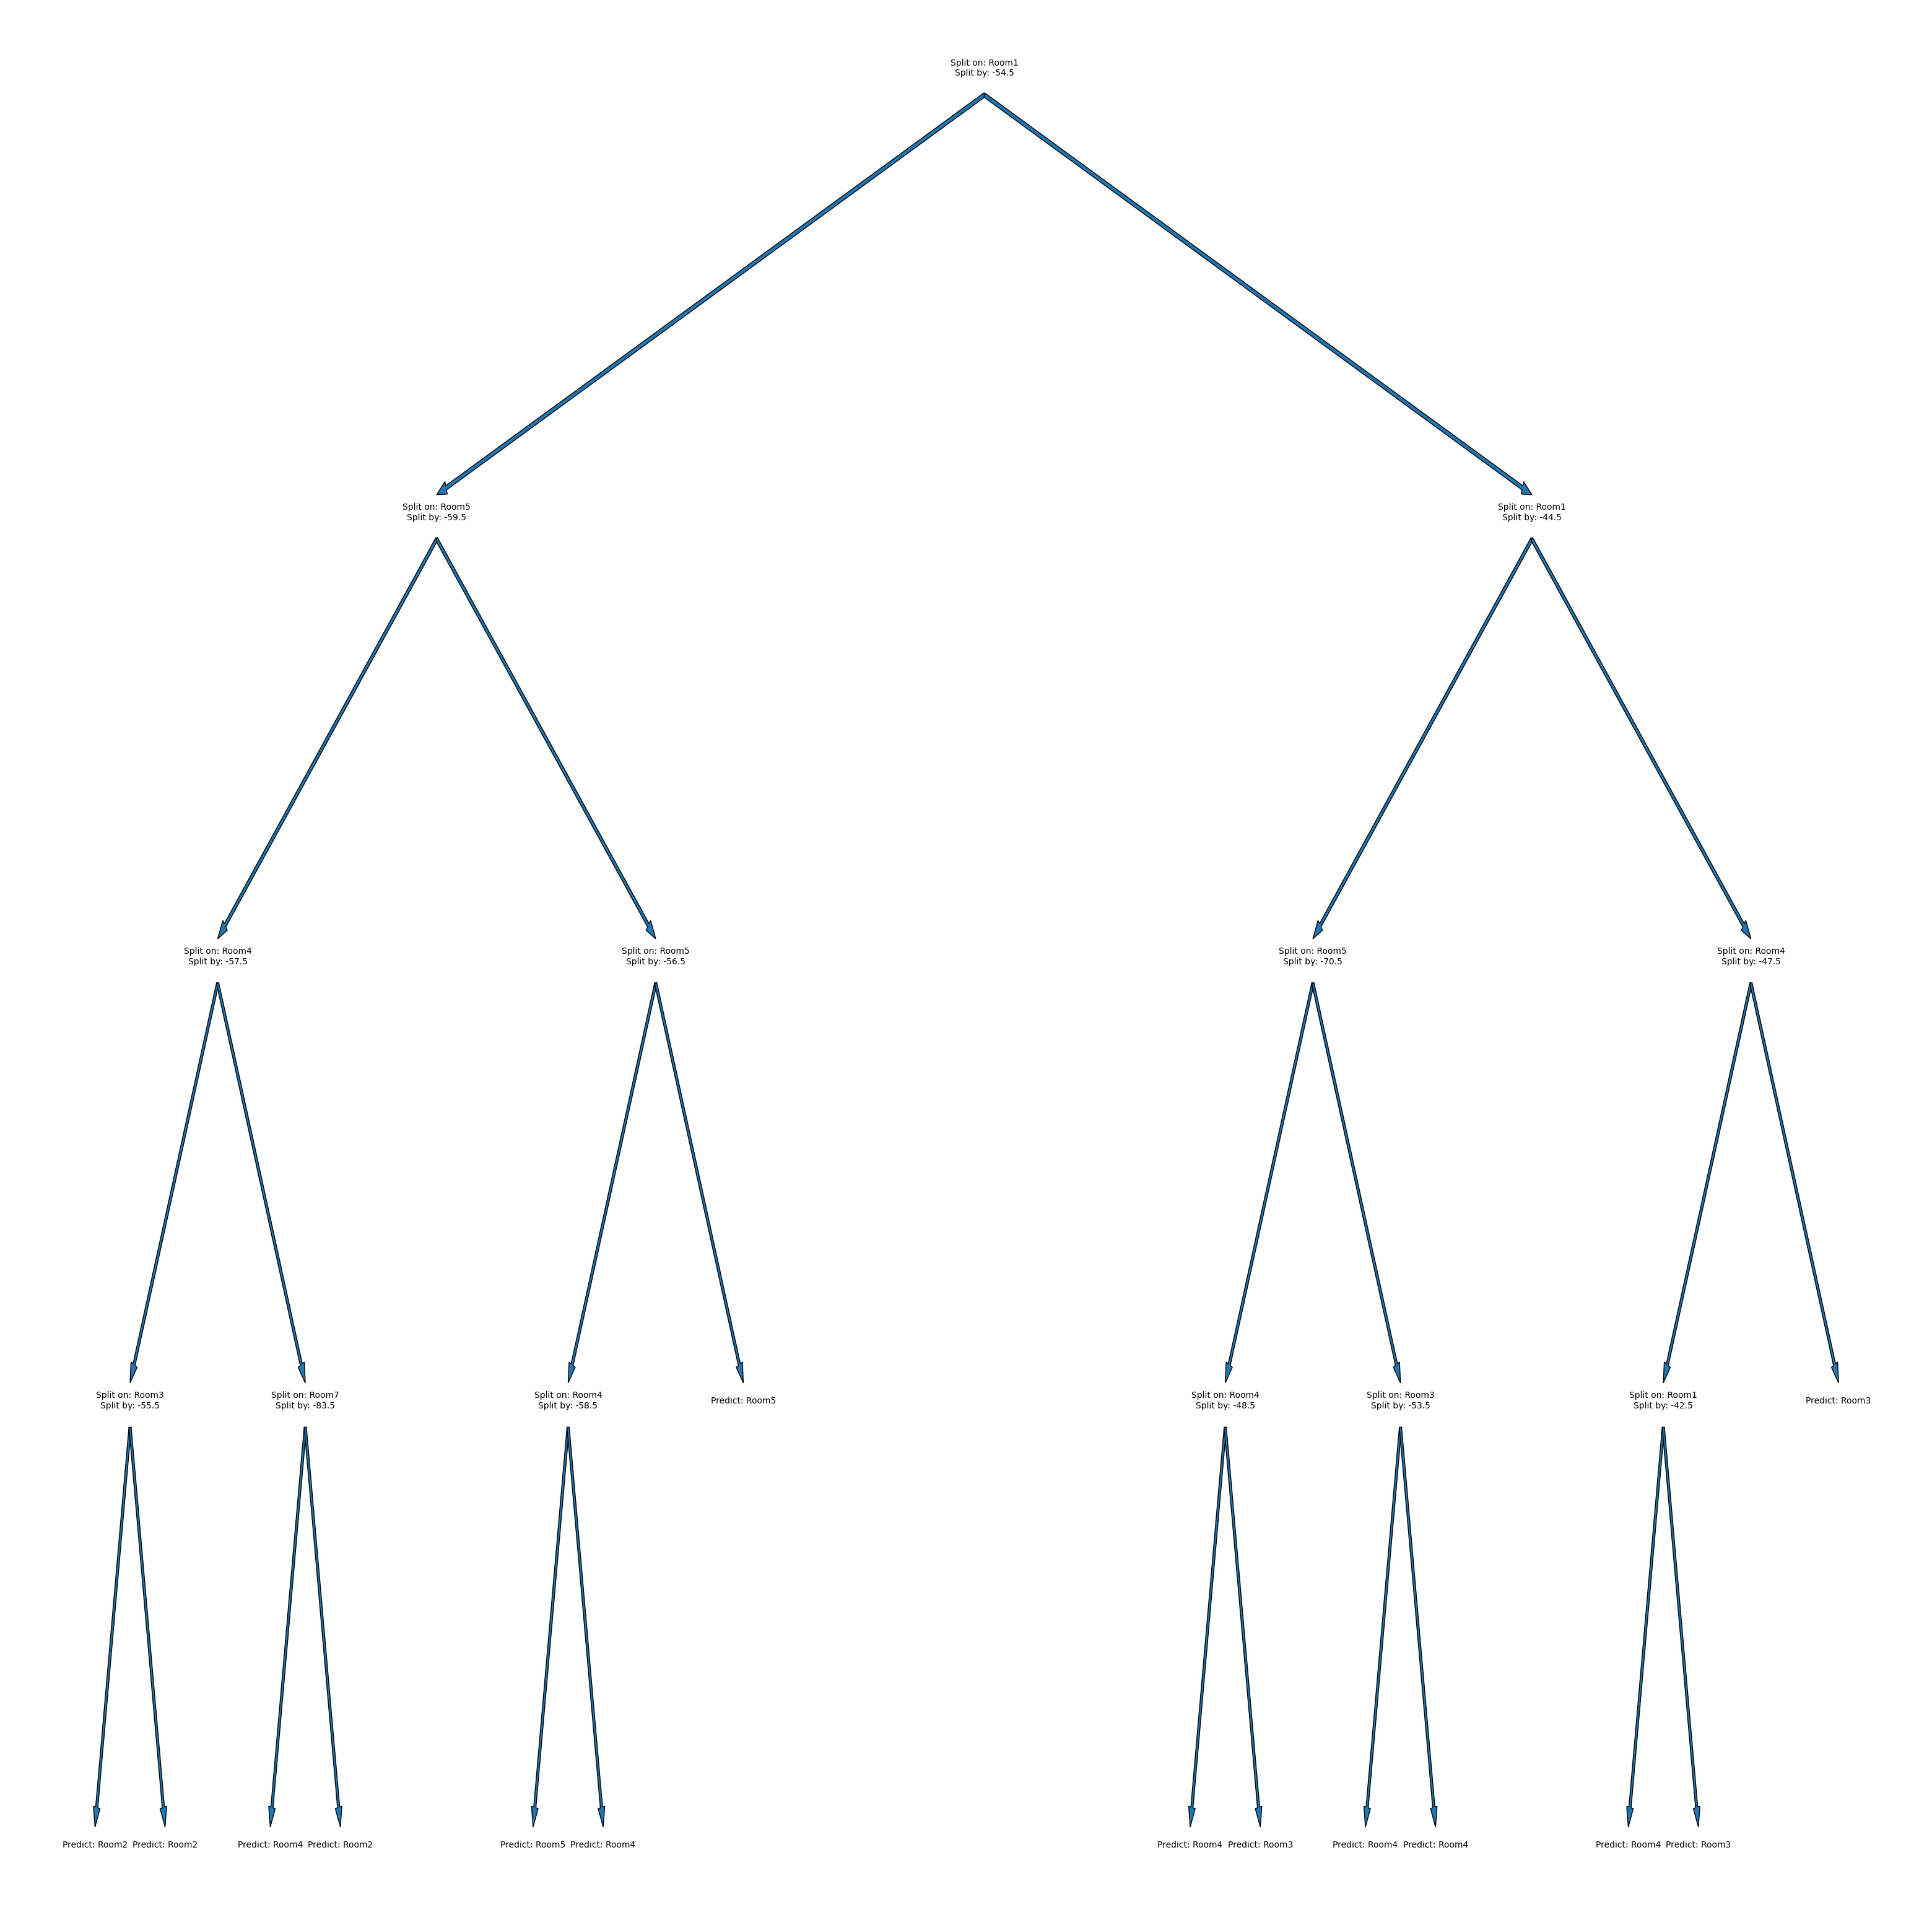

In [21]:
#Function counts the number of children nodes from a parent node
def countChildren(tree):
    if tree['isLeaf']:
        return 1
    else:
        left_tree = tree['left']
        right_tree = tree['right']
        return countChildren(left_tree) + countChildren(right_tree)

#Function uses recursion to plot the nodes in the decision tree and links them with arrows
def plotDecisionTree(tree, x_cord, y_cord, offset):
    #If leaf node is reach
    if tree['isLeaf']:
        #Print the predicted room
        node_label = f"Predict: Room{int(tree['max_attribute']+1)}"
        plt.text(x_cord, y_cord, node_label, ha='center', va='center')
        return 1
    
    #Else if node is a child node
    else:
        left_tree = tree['left']
        right_tree = tree['right']
        #Print the feature the node will be split on and the split value
        node_label = f"Split on: Room{ tree['attribute']+1}\nSplit by: {tree['split']}"
        plt.text(x_cord, y_cord, node_label, ha='center', va='center')

        #Creates an offset so that all the children nodes can fit in a single row
        left_offset = right_offset = offset / 2.5

        #Coordinates of the elft and right children node
        left_child_x = (x_cord - left_offset)
        left_child_y = (y_cord - 0.5)

        right_child_x = (x_cord + right_offset)
        right_child_y = (y_cord - 0.5)

        #Plot arrows from the parent node to the left and right child node
        plt.arrow(x_cord, y_cord-0.03, left_child_x - x_cord, left_child_y - y_cord+0.05, length_includes_head=True, width=0.005)
        plt.arrow(x_cord, y_cord-0.03, right_child_x - x_cord, right_child_y - y_cord+0.05, length_includes_head=True, width=0.005)

        #Recursively calls the plotDecisionTree function to plot the decision tree
        plotDecisionTree(left_tree, x_cord - left_offset, y_cord - 0.5, left_offset)
        plotDecisionTree(right_tree, x_cord + right_offset, y_cord - 0.5, right_offset)

#Call function to plot the final decision tree (Calls countChildren & plotDecisionTree functions)
#Function takes in the decision tree and max_horizontal_len (which is the length of the final depth of the tree, length must be selected such that all the final depth nodes will not overlap with each other)
def visualise_tree(tree, max_horizontal_len):
    #Calculates the initial offset to be used in the plotDecisionTree function
    num_of_nodes = countChildren(tree.tree)
    initial_span = max_horizontal_len / (num_of_nodes - 1)
    plt.figure(figsize=(max_horizontal_len, max_horizontal_len))
    plotDecisionTree(tree.tree, 0.5, 2, initial_span)
    plt.axis('off')
    plt.show()

#Call the function visualise_tree
visualise_tree(clean_trees[0], 40)